# Task P2.1
## Realize an implementation of the Kalman Filter in a programming language of your choice for a simulation of the ball-throwing example from the lecture slides. The task of your Kalman Filter is to estimate the position and velocity vector of the ball only from the observed erroneous positions over time.

# Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from kalmanfilter_script import *  # all functioned within the kalmanfilter script file

## Your implementation shall be flexible in the sense that it can handle the following variations:

* Simulate the trajectory of a ball with the parameters launch position (especially the height above an imaginary ground), launch speed and launch angle of the ball.

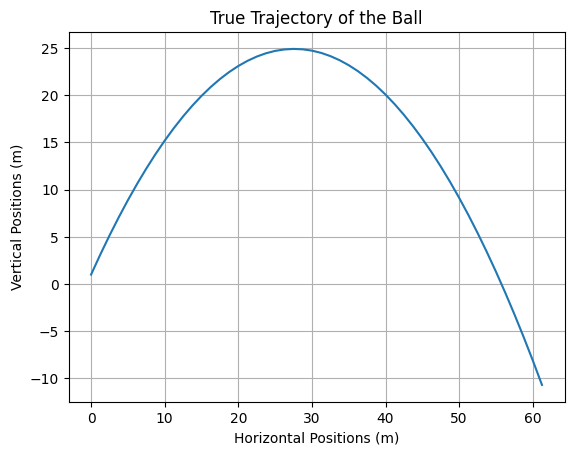

In [2]:
# Define the required parameters
g = 9.81  # Gravity (m/s^2)
dt = 0.1  # Time step (ssecond)
total_time = 5  # Total simulation time (second)

# Ball trajectory parameters
launch_position = np.array([0, 1])  # Initial position of the ball in the coordinate system(x0, y0)
launch_speed = 25  # Launch speed or the first speed and velocity in (meter/second)
launch_angle = 60  # Launch angle (degrees)

true_positions_of_the_ball = simulate_ball_trajectory(dt, total_time, launch_position, launch_speed, launch_angle) # it shows the true positions of the ball
simulate_ball_trajectory_plot(true_positions_of_the_ball) # it plots the true trajectory of the ball

* Simulate the observation of the ball position (x,y as shown in the slides). The estimated ball position shall be subject to uncertainty and it shall be possible to parameterize this uncertainty. In addition, the time span between two observations shall be variable and the observations shall be able to drop out completely over a certain period of time.

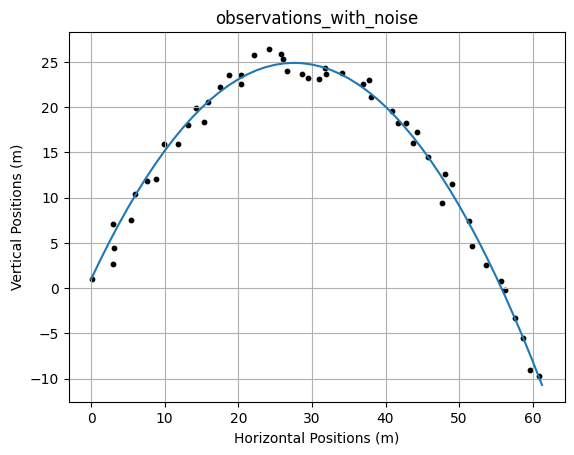

In [14]:
obs_noise_std = np.array([0.9, 0.9])  # Standard deviation of observation noise
observations_with_noise = simulate_observations_with_noise(true_positions_of_the_ball, obs_noise_std) # add the noise or uncertainty to the true positions of the ball

# it plots the observations with the added noise
plt.plot(true_positions_of_the_ball[:, 0], true_positions_of_the_ball[:, 1])
plt.scatter(observations_with_noise[:, 0], observations_with_noise[:, 1], c='black', s=10)
plt.xlabel('Horizontal Positions (m)')
plt.ylabel('Vertical Positions (m)')
plt.title('observations_with_noise')
plt.grid(True)
plt.show()

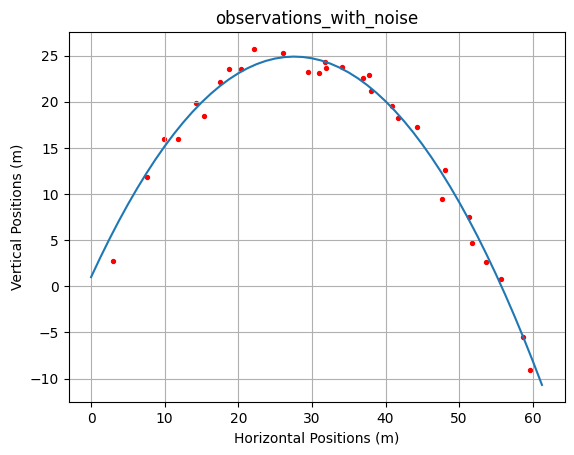

In [20]:
dropout_prob = 0.3 # the dropout probability in range [0,1]
observations_with_noise_dropout = simulate_observation_dropouts(observations_with_noise, dropout_prob) # it adds the dropout probability 0.1 to the noisey observations we created in the previous cell
# it plots the noisy observations with the added dropout probability
plt.plot(true_positions_of_the_ball[:, 0], true_positions_of_the_ball[:, 1])
#plt.scatter(observations_with_noise[:, 0], observations_with_noise[:, 1], c='black', s=10)
plt.scatter(observations_with_noise_dropout[:, 0], observations_with_noise_dropout[:, 1], c='red', s=8)
plt.xlabel('Horizontal Positions (m)')
plt.ylabel('Vertical Positions (m)')
plt.title('observations_with_noise')
plt.grid(True)
plt.show()

* The initial parameters of the Kalman Filter shall be adaptable.

In [21]:
# Kalman Filter parameters

# State transition matrix or system model (n x n), and dt is the time span
'''
  n = 4, because we have positions for x, y and then velocity on both directions vx, vy
'''
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# Control input matrix (n x k) (gravity effect on velocity of state transition A), and dt time span with g gravity
'''
  Control affects only the velocity in the y direction due to gravity
  and that is why the first col is 0 but the 2nd col has g added
'''
B = np.array([[0, 0],
              [0, 0],
              [0, 0],
              [0, -g * dt]])

# Observation model or state to measurement (m x n)
'''
  m = 2 becuase we are taken only x and y measurement not the vx and vy
  so the first rows shows it takes only x into considerations and
  ignore other elements form state transition matrix A,
  and the same in the second row we take only y into consideration.
'''
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Process noise covariance matrix (n x n) shows the uncertainty or noise in the model
'''
  it adds uncertainty in the process which contains x,y,vx, and vy that is why it has to be
  size of n x n, n =4
'''
Q = np.diag([0.1, 0.1, 0.1, 0.1])

# Observation noise covariance matrix (m x m) uncertainty in the measurement
'''
  it adds uncertainty only for the measurements, that our measurement here are only
  positions for x and y so that is why the size for R is m x m, m =2
'''
R = np.diag([0.5, 0.5])

# Calculate initial velocity components
vx0 = launch_speed * np.cos(np.radians(launch_angle))
vy0 = launch_speed * np.sin(np.radians(launch_angle))

# Initial state estimate (n x 1) (x, y, vx, vy)
x_hat_init = np.array([0, 1, vx0, vy0])

# Initial state covariance matrix (n x n) or uncertainty in state estimation
P_init = np.eye(4)



# Define Kalman Filter parameters
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

B = np.array([[0, 0],
              [0, 0],
              [0, 0],
              [0, -g * dt]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Define initial state and covariance
x_hat_init = np.array([0, 1, vx0, vy0])
P_init = np.eye(4)

# Different Q and R values for testing
Q_values = [np.diag([0.3, 0.3, 0.3, 0.3])]
R_values = [np.diag([4.0, 4.0])]

### Instantiate the object of Kalman Filter Class

In [22]:
# Kalman filter object creationt
kalman_filter = KalmanFilter(A, B, H, Q, R, x_hat_init, P_init)

# Kalman Filter estimation
kf_estimates = []
time_steps = int(total_time / dt)
for t in range(time_steps):
    # Prediction Step: call the predict function of Kalman Filter
    kalman_filter.predict(np.array([0, 1]))

    # Update Step with observation if available: Use the update function of Kalman Filter
    # We can use noisy observation without dropout probs or with dropout probs
    estimates = kalman_filter.update(observations_with_noise[t])
    kf_estimates.append(estimates)
kf_estimates = np.array(kf_estimates)

### Plot the Estimations with Kalman Filter

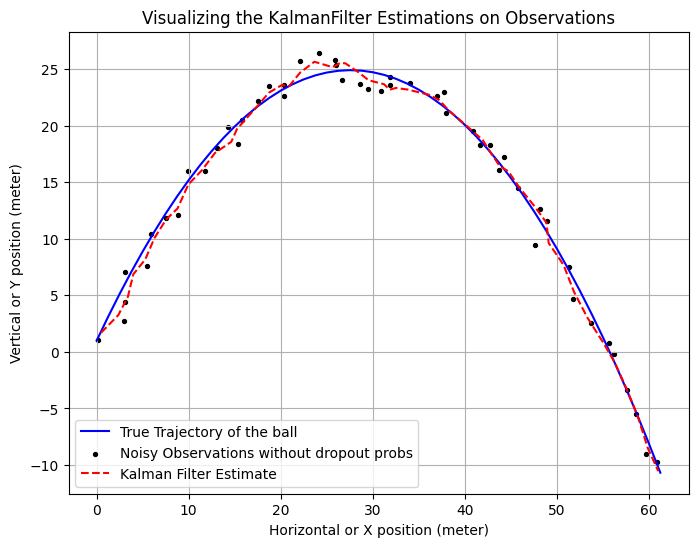

In [23]:
# Plot the Kalman Filter Estimation
plt.figure(figsize=(8, 6))
plt.plot(true_positions_of_the_ball[:, 0], true_positions_of_the_ball[:, 1], label='True Trajectory of the ball', color='blue')
plt.scatter(observations_with_noise[:, 0], observations_with_noise[:, 1], label='Noisy Observations without dropout probs', color='black', s=8)
#plt.scatter(observations_with_noise_dropout[:, 0], observations_with_noise_dropout[:, 1], label='Noisy Observations with dropout probs', color='gray', s=6)
plt.plot(kf_estimates[:, 0], kf_estimates[:, 1], label='Kalman Filter Estimate', linestyle='--', color='r')
plt.xlabel('Horizontal or X position (meter)')
plt.ylabel('Vertical or Y position (meter)')
plt.title('Visualizing the KalmanFilter Estimations on Observations')
plt.legend()
plt.grid()
plt.show()

*  The normally distributed noise on transition and observation should be adjustable. This means that the covariance matrices R and Q shall be set as a parameter in the Kalman Filter.

In [27]:
# Process noise covariance matrix
Q1 = np.diag([0.2, 0.2, 0.2, 0.2])

# Observation noise covariance matrix
R1 = np.diag([0.5, 0.5])

In [28]:
# Kalman filter object creationt
kalman_filter1 = KalmanFilter(A, B, H, Q1, R1, x_hat_init, P_init)

# Kalman Filter estimation
kf_estimates1 = []
time_steps = int(total_time / dt)
for t in range(time_steps):
    # Prediction Step: call the predict function of Kalman Filter
    kalman_filter1.predict(np.array([0, 1]))

    # Update Step with observation if available: Use the update function of Kalman Filter
    # We can use noisy observation without dropout probs or with dropout probs
    estimates = kalman_filter1.update(observations_with_noise[t])
    kf_estimates1.append(estimates)
kf_estimates1 = np.array(kf_estimates1)

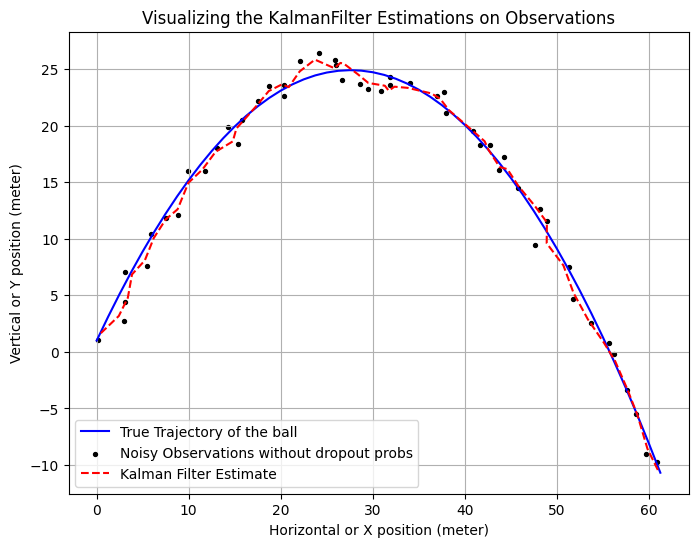

In [29]:
# Plot the Kalman Filter Estimation
plt.figure(figsize=(8, 6))
plt.plot(true_positions_of_the_ball[:, 0], true_positions_of_the_ball[:, 1], label='True Trajectory of the ball', color='blue')
plt.scatter(observations_with_noise[:, 0], observations_with_noise[:, 1], label='Noisy Observations without dropout probs', color='black', s=8)
#plt.scatter(observations_with_noise_dropout[:, 0], observations_with_noise_dropout[:, 1], label='Noisy Observations with dropout probs', color='gray', s=6)
plt.plot(kf_estimates1[:, 0], kf_estimates1[:, 1], label='Kalman Filter Estimate', linestyle='--', color='r')
plt.xlabel('Horizontal or X position (meter)')
plt.ylabel('Vertical or Y position (meter)')
plt.title('Visualizing the KalmanFilter Estimations on Observations')
plt.legend()
plt.grid()
plt.show()

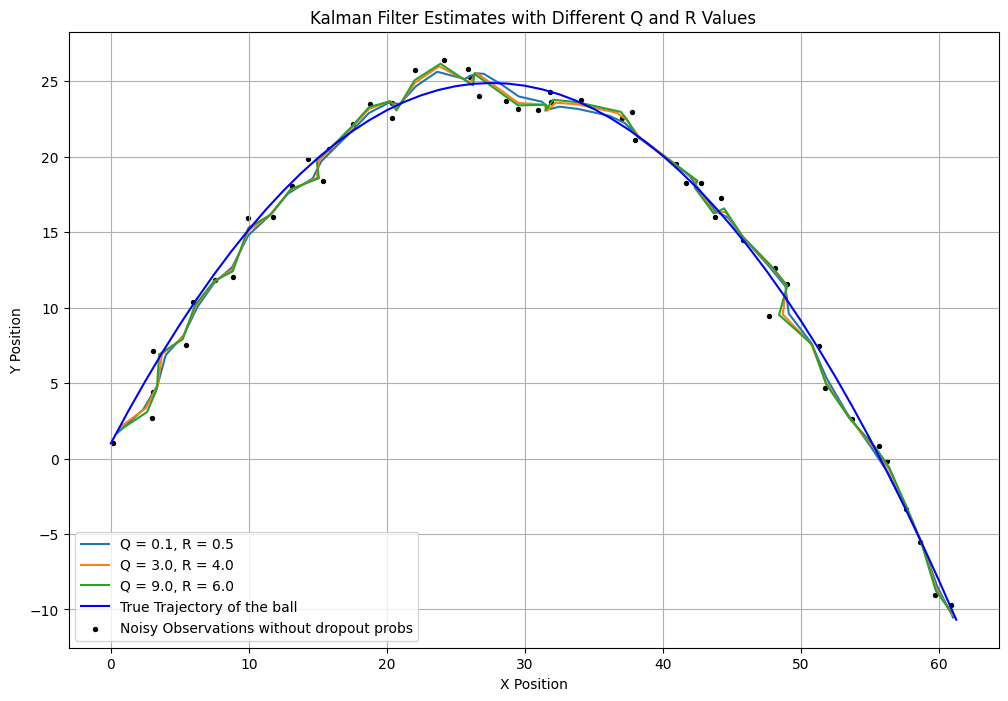

In [34]:
# Define the different sets of Q and R values for testing
Qvalues = [
    np.diag([0.1, 0.1, 0.1, 0.1]),
    np.diag([3.0, 3.0, 3.0, 3.0]),
    np.diag([9.0, 9.0, 9.0, 9.0])
]

Rvalues = [
    np.diag([0.5, 0.5]),
    np.diag([4.0, 4.0]),
    np.diag([6.0, 6.0])
]

# Plotting
plt.figure(figsize=(12, 8))
time_steps = int(total_time / dt)

for Q, R in zip(Qvalues, Rvalues):
    kalman_filter = KalmanFilter(A, B, H, Q, R, x_hat_init, P_init)
    kf_estimates = []
    for t in range(time_steps):
        kalman_filter.predict(np.array([0, 1]))
        estimates = kalman_filter.update(observations_with_noise[t])
        kf_estimates.append(estimates)
    kf_estimates = np.array(kf_estimates)
    plt.plot(kf_estimates[:, 0], kf_estimates[:, 1], label=f'Q = {Q[0,0]}, R = {R[0,0]}')

plt.plot(true_positions_of_the_ball[:, 0], true_positions_of_the_ball[:, 1], label='True Trajectory of the ball', color='blue')
plt.scatter(observations_with_noise[:, 0], observations_with_noise[:, 1], label='Noisy Observations without dropout probs', color='black', s=8)
#plt.scatter(observations_with_noise_dropout[:, 0], observations_with_noise_dropout[:, 1], label='Noisy Observations with dropout probs', color='gray', s=6)
plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Kalman Filter Estimates with Different Q and R Values')
plt.grid()
plt.show()